# Fusion of Thermal and Visible Ear Images for improved Biometric identification Using Unsupervised Learning

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.decomposition import PCA
from metrics import Metric,SSIM_function,PSNR_function,Qabf_function,Nabf_function,MI_function,MSE_function,SCD_function,MS_SSIM_function


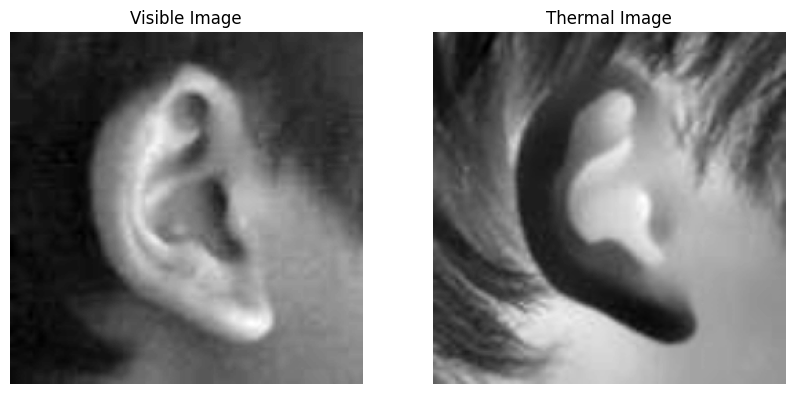

In [3]:


vi_image_path = r"C:\Users\sriram\Desktop\SMEC ECE\SEC - D projects\DIAST Variability Illuminated Thermal and Visible Ear Images code\DIAST Variability Illuminated Thermal and Visible Ear Images Datasets\Dataset\RIGHT\Right Visible\R02x0133v2.jpg"
ir_image_path = r"C:\Users\sriram\Desktop\SMEC ECE\SEC - D projects\DIAST Variability Illuminated Thermal and Visible Ear Images code\DIAST Variability Illuminated Thermal and Visible Ear Images Datasets\Dataset\RIGHT\Right Thermal\R02x0133t2.jpg"

vi_image = cv2.imread(vi_image_path, cv2.IMREAD_GRAYSCALE)
ir_image = cv2.imread(ir_image_path, cv2.IMREAD_GRAYSCALE)

target_size = (256, 256)  # Choose the target size (width, height)

vi_image = cv2.resize(vi_image, target_size, interpolation=cv2.INTER_LINEAR)
ir_image = cv2.resize(ir_image, target_size, interpolation=cv2.INTER_LINEAR)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(vi_image, cmap='gray')
plt.title('Visible Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ir_image, cmap='gray')
plt.title('Thermal Image')
plt.axis('off')

plt.show()

In [4]:
def evaluate_fusion_performance(method, image_vi, image_ir, fused_image):
    import warnings
    warnings.filterwarnings('ignore')
    
    # Convert images to float32
    image_vi = image_vi.astype(np.float32)
    image_ir = image_ir.astype(np.float32)
    fused_image = fused_image.astype(np.float32)
    
    # Compute metrics
    ssim_score = SSIM_function(image_vi, image_ir, fused_image)
    psnr_score = PSNR_function(image_vi, image_ir, fused_image)
    qabf_score = Qabf_function(image_vi, image_ir, fused_image)
    mse_score = MSE_function(image_vi, image_ir, fused_image)
    ms_ssim_score = MS_SSIM_function(image_vi, image_ir, fused_image)
    
    # Print metrics
    print(f"{method} Method SSIM is {ssim_score:.4f}")
    print(f"{method} Method PSNR is {psnr_score:.4f}")
    print(f"{method} Method QABF is {qabf_score:.4f}")
    print(f"{method} Method MSE is {mse_score:.4f}")
    print(f"{method} Method MS SSIM is {ms_ssim_score:.4f}")
    
    return {
        'SSIM': ssim_score,
        'PSNR': psnr_score,
        'QABF': qabf_score,
        'MSE': mse_score,
        'MS SSIM': ms_ssim_score
    }


In [5]:
def plot_comparison(label1, metrics_method1, label2, metrics_method2):
    # Data for plotting
    labels = list(metrics_method1.keys())
    num_metrics = len(labels)
    
    fig = plt.figure(figsize=(12, num_metrics * 4))
    
    for i, label in enumerate(labels):
        plt.subplot(num_metrics, 1, i + 1)  # Subplot position
        
        # Data for current metric
        method1_score = metrics_method1[label]
        method2_score = metrics_method2[label]
        
        x = np.array([0, 1])  # X locations for the bars
        method_scores = [method1_score, method2_score]
        width = 0.35  # Width of bars
        
        # Plot bars
        bars = plt.bar(x - width/2, method_scores, width, color=['b', 'r'], tick_label=[label1, label2], label=[label1, label2])
        
        # Set labels and title
        plt.ylabel('Score')
        plt.title(f'{label}')
        
        # Add values on top of bars
        def add_values(bars):
            for bar in bars:
                height = bar.get_height()
                plt.annotate(f'{height:.2f}',
                             xy=(bar.get_x() + bar.get_width() / 2, height),
                             xytext=(0, 3),  # 3 points vertical offset
                             textcoords="offset points",
                             ha='center', va='bottom')
        
        add_values(bars)
        
        # Add legend
        plt.legend()
    
    # Set x-ticks and labels for the last subplot
    plt.subplot(num_metrics, 1, num_metrics)  # Last subplot
    plt.xticks(x, [label1, label2])
    plt.xlabel('Methods')
    
    plt.tight_layout()
    plt.show()

In [6]:
def swt_fusion(vi_image, ir_image, level=1):
    # Ensure input images have the same shape
    min_shape = min(vi_image.shape, ir_image.shape)
    vi_image = vi_image[:min_shape[0], :min_shape[1]]
    ir_image = ir_image[:min_shape[0], :min_shape[1]]

    # Decompose visible and infrared images using SWT
    vis_coeffs = pywt.swt2(vi_image, 'db4', level=level)
    ir_coeffs = pywt.swt2(ir_image, 'db4', level=level)

    # Perform PCA-based fusion rule
    fused_coeffs = []
    for (vis_appro, vis_detail), (ir_appro, ir_detail) in zip(vis_coeffs, ir_coeffs):
        fused_detail = []
        for i in range(len(vis_detail)):
            # Compute PCA
            pca = PCA(n_components=1)
            vis_pca = pca.fit_transform(vis_detail[i].reshape(-1, 1))
            ir_pca = pca.transform(ir_detail[i].reshape(-1, 1))

            # Fuse using maximum rule
            fused_pca = np.maximum(vis_pca, ir_pca)

            # Reshape back to original shape
            fused_pca = fused_pca.reshape(vis_detail[i].shape)
            fused_detail.append(fused_pca)

        fused_coeffs.append((vis_appro, tuple(fused_detail)))

    # Reconstruct fused image from coefficients
    fused_image = pywt.iswt2(fused_coeffs, 'db4')

    # Normalize pixel values to 0-255 range
    fused_image = cv2.normalize(fused_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return fused_image


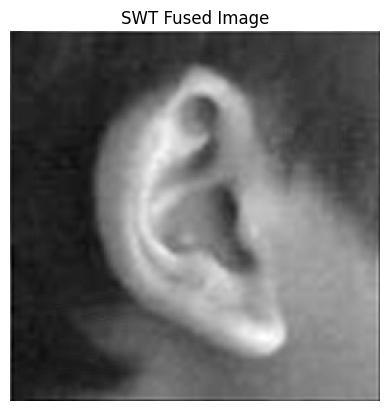

torch.Size([1, 1, 1, 256, 256]) torch.Size([1, 1, 1, 256, 256])
torch.Size([1, 1, 1, 256, 256]) torch.Size([1, 1, 1, 256, 256])
SWT Method SSIM is -0.0837
SWT Method PSNR is 57.4373
SWT Method QABF is 0.2034
SWT Method MSE is 0.1173
SWT Method MS SSIM is 0.0000


In [7]:
fused_image = swt_fusion(vi_image, ir_image)

plt.figure()
plt.imshow(fused_image, cmap='gray')
plt.title('SWT Fused Image')
plt.axis('off')
plt.show()
fused_image = cv2.GaussianBlur(fused_image, (0, 0), 1)
swt_results=evaluate_fusion_performance('SWT', vi_image, fused_image, ir_image)

In [8]:
def multi_level_gaussian_laplacian_pyramid_decomposition(vi_image, ir_image, levels=3):
    # Gaussian pyramid for visible image
    vi_pyramid = [vi_image.astype(np.float32)]
    for _ in range(levels - 1):
        vi_image = cv2.pyrDown(vi_image)
        vi_pyramid.append(vi_image.astype(np.float32))

    # Gaussian pyramid for infrared image
    ir_pyramid = [ir_image.astype(np.float32)]
    for _ in range(levels - 1):
        ir_image = cv2.pyrDown(ir_image)
        ir_pyramid.append(ir_image.astype(np.float32))

    # Laplacian pyramid for visible image
    vi_laplacian = [vi_pyramid[levels - 1]]
    for i in range(levels - 2, -1, -1):
        vi_expanded = cv2.pyrUp(vi_pyramid[i + 1], dstsize=(vi_pyramid[i].shape[1], vi_pyramid[i].shape[0]))
        vi_laplacian.append(vi_pyramid[i] - vi_expanded)

    # Laplacian pyramid for infrared image
    ir_laplacian = [ir_pyramid[levels - 1]]
    for i in range(levels - 2, -1, -1):
        ir_expanded = cv2.pyrUp(ir_pyramid[i + 1], dstsize=(ir_pyramid[i].shape[1], ir_pyramid[i].shape[0]))
        ir_laplacian.append(ir_pyramid[i] - ir_expanded)

    # Blend the Laplacian pyramids
    blended_laplacian = []
    for vi_layer, ir_layer in zip(vi_laplacian, ir_laplacian):
        blended_laplacian.append(vi_layer * 0.5 + ir_layer * 0.5)

    # Reconstruct the fused image
    fused_image = blended_laplacian[0]
    for i in range(1, levels):
        fused_image = cv2.pyrUp(fused_image, dstsize=(blended_laplacian[i].shape[1], blended_laplacian[i].shape[0]))
        fused_image += blended_laplacian[i]

    # Normalize pixel values to 0-255 range
    fused_image = cv2.normalize(fused_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    fig, axs = plt.subplots(levels, 4, figsize=(12, 12))

    # Display each level of the Laplacian and Gaussian pyramids
    for i in range(levels):
        axs[i, 0].imshow(vi_pyramid[i], cmap='gray')
        axs[i, 0].set_title(f'Visible Gaussian Level {i+1}')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(ir_pyramid[i], cmap='gray')
        axs[i, 1].set_title(f'Theraml Gaussian Level {i+1}')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(vi_laplacian[i], cmap='gray')
        axs[i, 2].set_title(f'Visible Laplacian Level {i+1}')
        axs[i, 2].axis('off')

        axs[i, 3].imshow(ir_laplacian[i], cmap='gray')
        axs[i, 3].set_title(f'Infrared Laplacian Level {i+1}')
        axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()
    
    return fused_image

In [9]:
def gaussian_blur_retinex(image, sigma_list=[15, 80, 250]):
    retinex = np.zeros_like(image, dtype=np.float32)
    for sigma in sigma_list:
        gaussian = cv2.GaussianBlur(image, (0, 0), sigma)
        retinex = np.maximum(retinex, np.log(image + 1) - np.log(gaussian + 1))
    return retinex

def Normalized_gaussian_blur_retinex(vi_image, ir_image):
    # Convert images to float32 for processing
    vi_image = vi_image.astype(np.float32)
    ir_image = ir_image.astype(np.float32)

    # Perform multi-scale retinex enhancement
    vi_retinex = gaussian_blur_retinex(vi_image)
    ir_retinex = gaussian_blur_retinex(ir_image)

    # Fuse retinex-enhanced images using weighted averaging
    fused_retinex = 0.5 * (vi_retinex + ir_retinex)

    # Normalize pixel values to 0-255 range
    fused_image = cv2.normalize(fused_retinex, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return fused_image


In [10]:
def hybrid_fusion(vi_image, ir_image, levels=3):
    # Perform  pyramid blending
    global pyramid_fused,retinex_fused
    pyramid_fused = multi_level_gaussian_laplacian_pyramid_decomposition(vi_image, ir_image, levels)
    
    # Perform multi-scale retinex fusion
    retinex_fused = Normalized_gaussian_blur_retinex(vi_image, ir_image)
    
    # Combine fused images using weighted averaging
    hybrid_fused = 0.5 * (pyramid_fused.astype(np.float32) + retinex_fused.astype(np.float32))

    # Normalize pixel values to 0-255 range
    hybrid_fused = cv2.normalize(hybrid_fused, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return hybrid_fused

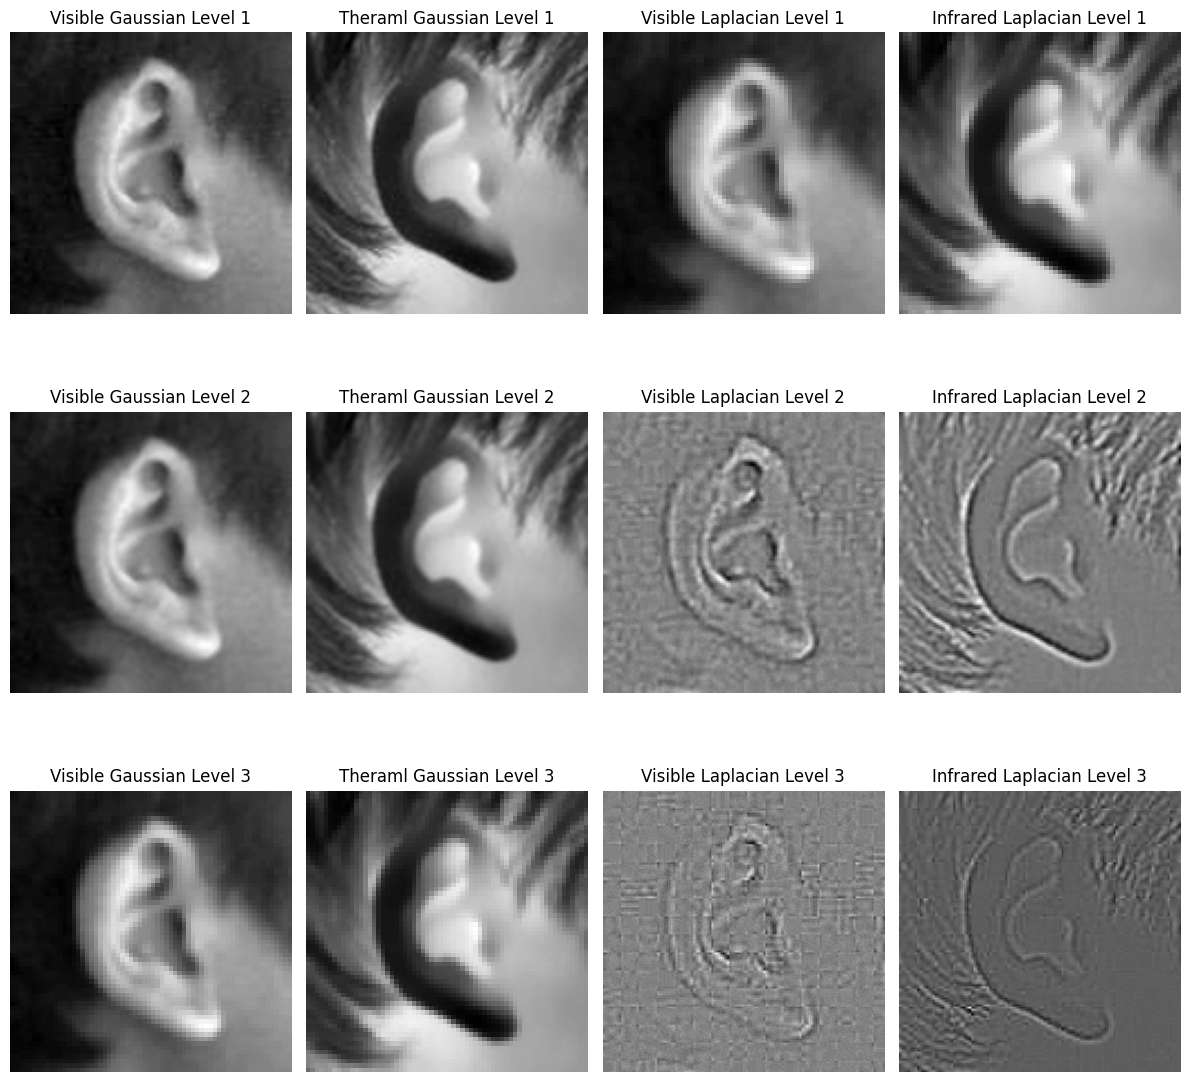

In [11]:
fused_image = hybrid_fusion(vi_image, ir_image)

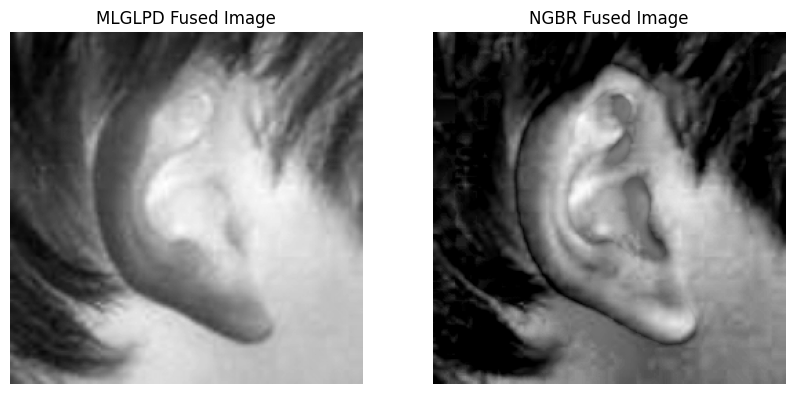

In [12]:
global pyramid_fused,retinex_fused
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pyramid_fused, cmap='gray')
plt.title('MLGLPD Fused Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(retinex_fused, cmap='gray')
plt.title('NGBR Fused Image')
plt.axis('off')

plt.show()

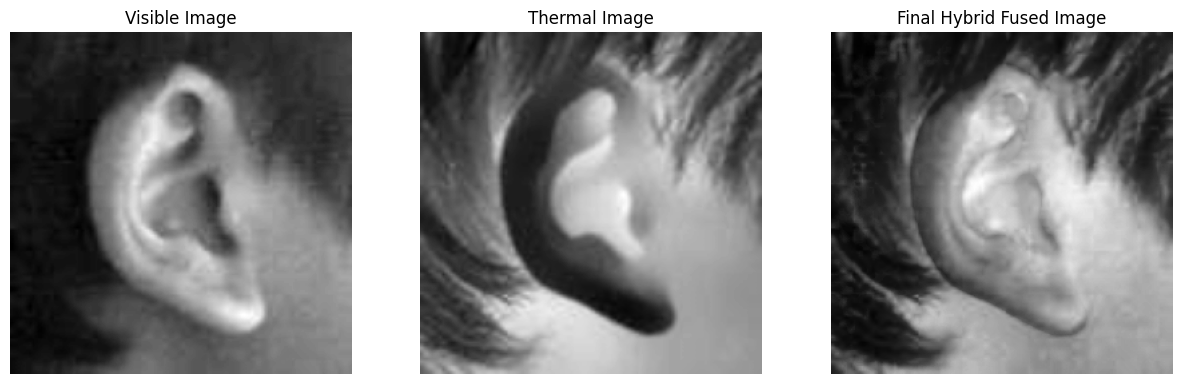

In [13]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 3, 1)
plt.imshow(vi_image, cmap='gray')
plt.title('Visible Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ir_image, cmap='gray')
plt.title('Thermal Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(fused_image, cmap='gray')
plt.title('Final Hybrid Fused Image')
plt.axis('off')

plt.show()
ir_image=fused_image

In [14]:
proposed_results=evaluate_fusion_performance('Hybrid Fusion', ir_image, vi_image, fused_image)

torch.Size([1, 1, 1, 256, 256]) torch.Size([1, 1, 1, 256, 256])
torch.Size([1, 1, 1, 256, 256]) torch.Size([1, 1, 1, 256, 256])
Hybrid Fusion Method SSIM is 0.6412
Hybrid Fusion Method PSNR is 62.4517
Hybrid Fusion Method QABF is 0.7939
Hybrid Fusion Method MSE is 0.0370
Hybrid Fusion Method MS SSIM is 0.6714


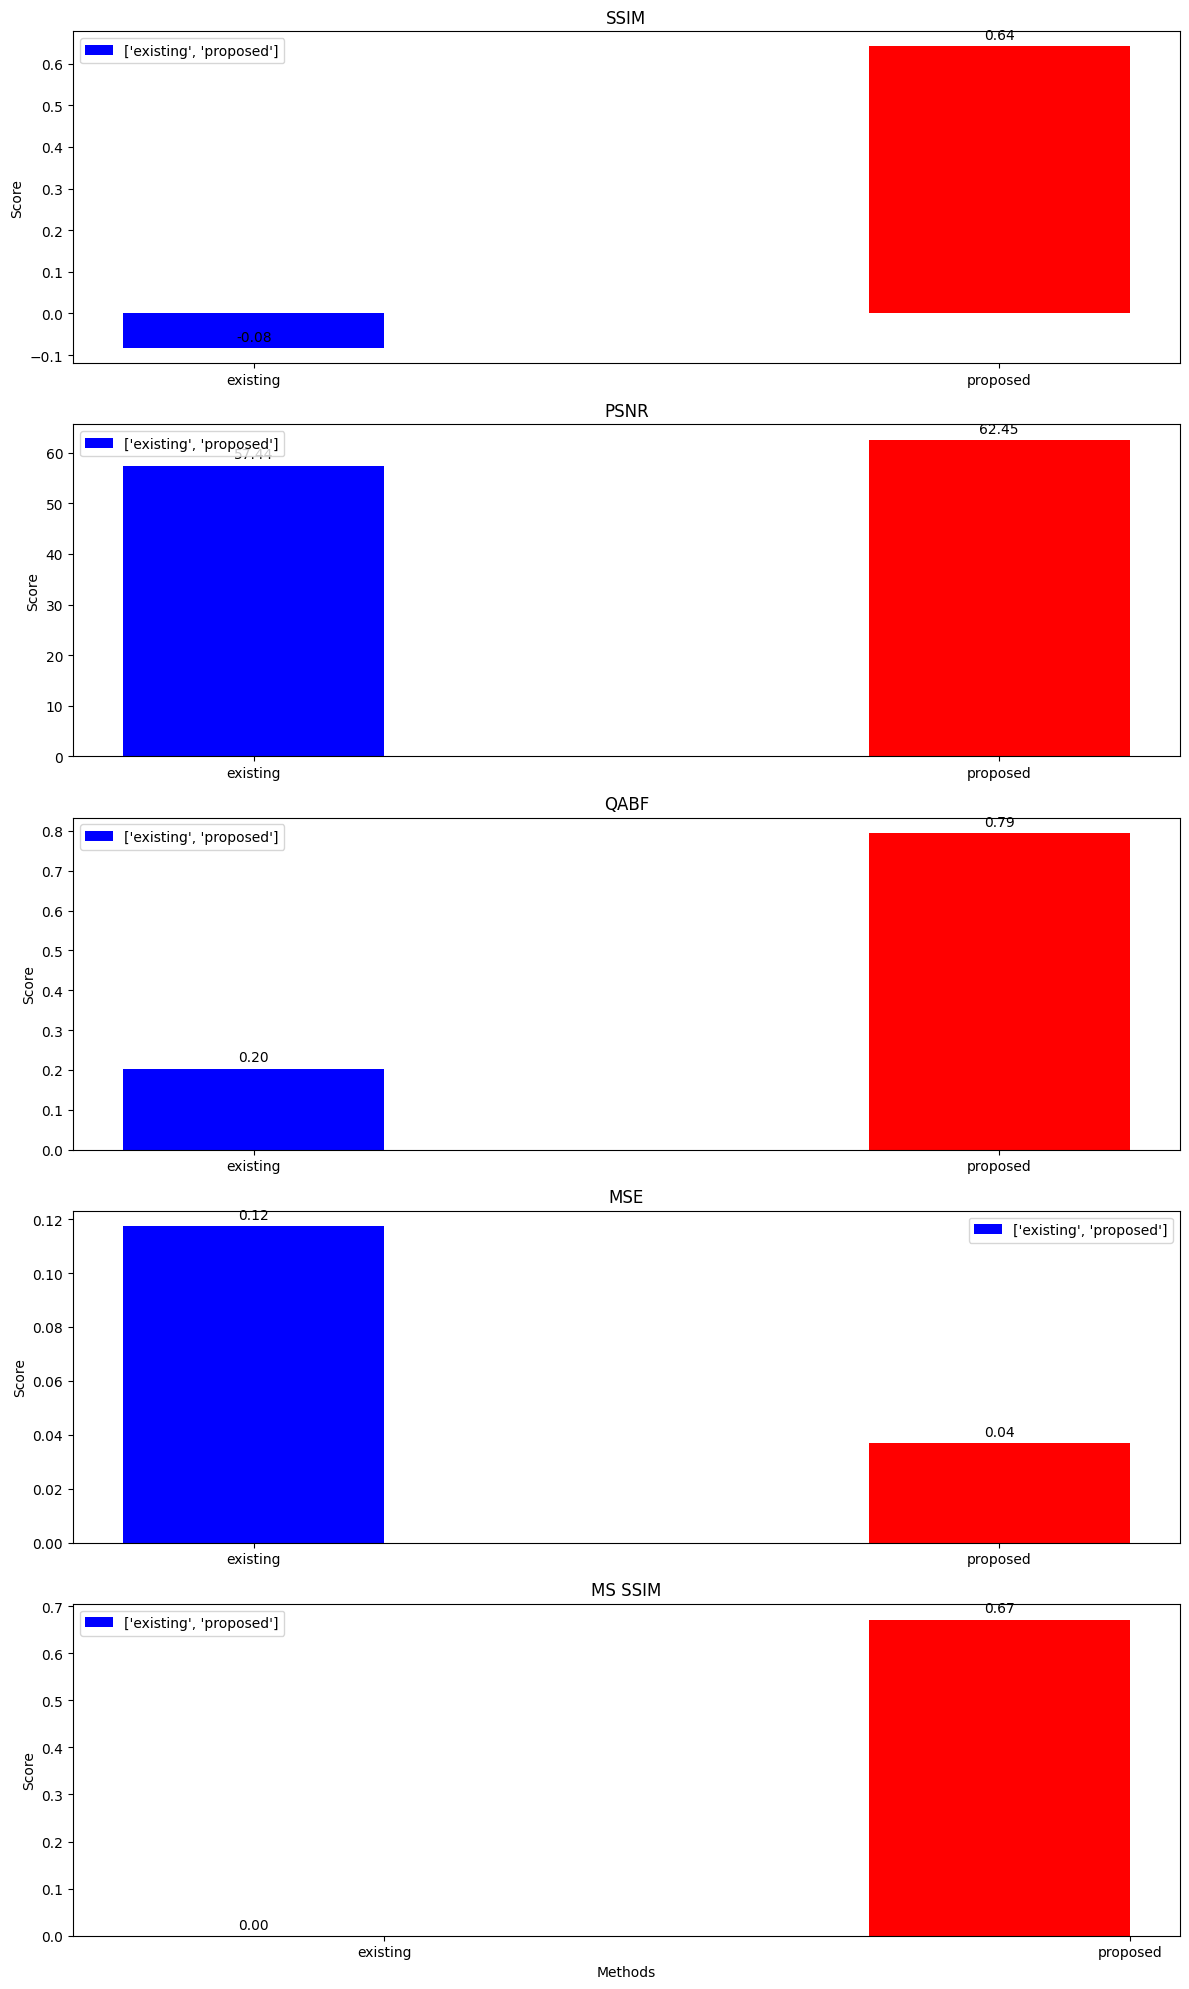

In [15]:
plot_comparison('existing',swt_results, 'proposed',proposed_results)